# Is Science Becoming Less Disruptive?

A [recent paper in Nature](https://www.nature.com/articles/s41586-022-05543-x) created a stir in the scientific community, arguing that science is becoming less disruptive over time. According to the study, there are fewer groundbreaking papers in recent years. It appears that trailblazers are rare and that most research tends to build and expand existing research rather than opening up new paths of inquiry.

Needless to say, the paper created quite a bit of head-scratching: if science is becoming less disruptive, what, or who, is to blame? Could it be that the low hanging fruits have already been picked? That modern science requires over-specialisation, which entails working within a field of study, rather than exploring new vistas? The discussion raged even in mainstream media like [The Economist](https://www.economist.com/science-and-technology/2023/01/04/papers-and-patents-are-becoming-less-disruptive), [The New York Times](https://www.nytimes.com/2023/01/17/science/science-breakthroughs-disruption.html), [The Atlantic](https://www.theatlantic.com/newsletters/archive/2023/01/academia-research-scientific-papers-progress/672694/); then Nature returned with an [editorial on what it means and whether it matters](https://www.nature.com/articles/d41586-023-00183-1).

The debate will go on; in the meantime, we will try to make predictions on paper disruptivness.

---

> Alexios Doganis <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> t8190042@aueb.gr

### Predicting CD5

Disruption is measured by a metric, the [CD index](http://russellfunk.org/cdindex/), devised by the authors of the study. The CD is calculated over a time window, say five years (then it's called CD5), and it measures how likely is a work that cites a scientific paper to cite the works *that* paper cites. If follow-up work does not cite a paper's cited predecessors then it's likely that the paper has broken new ground.

The CD index can be calculated for each paper, by finding the works that cite it and the works that the paper itself cites. You can find details in the Nature paper and also in [the original paper that introduced the metric](http://russellfunk.org/cdindex/static/papers/funk_ms_2017.pdf). But then an interesting question arises: is it possible to *predict* a paper's CD5 index by using only the paper itself, information on its authors, and information on its citations, without looking into the future work that cites it?

The data tha we will use are in the form of an [SQLite](https://www.sqlite.org/) database. It is derived from the excellent [alexandria3k package](https://github.com/dspinellis/alexandria3k) written by [Professor Diomidis Spinellis](https://www2.dmst.aueb.gr/dds/). You can easily find the schema of the data with the standard SQLite facilities and you can also read the [documentation of alexandria3k](https://dspinellis.github.io/alexandria3k/). In particular, the data comprises part of the [publications graph](https://dspinellis.github.io/alexandria3k/cli-eg.html#publications-graph) for a 1% sample of all CrossRef available publications that have abstracts; an additional table in the database contains the CD5 index for papers.



We will first import the necessery libraries.

In [1]:
import sqlite3
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer

import xgboost as xgb
import lightgbm as lgb

from scipy.stats import sem
from io import StringIO
from IPython.display import Image  
import pydotplus

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


As stated above, the data used here are in a SQLite form and contain 1% sample of all CrossRef available publications that have abstracts. Even this small percentage is very big to upload in github (5GB). For this reason we are going to present the SQL used to extract the data and then convert the tables into pyhton [pickles](https://docs.python.org/3/library/pickle.html) which are way smaller in size.

First we connect with the sqlite database to obtain the data.
```python
con = sqlite3.connect('./publications_graph.db')
```

We need to fetch the database table names, so we can see the schema.
```python
cur = con.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(f"Table names : {cur.fetchall()}")
```
Which results in:

```Table names : [('works',), ('work_references',), ('author_affiliations',), ('work_subjects',), ('work_authors',), ('cdindex',)]```

Now we are going to load everything into pandas Dataframes
```python
works = pd.read_sql_query('SELECT * FROM works', con)
work_references = pd.read_sql_query('SELECT * FROM work_references;', con)
author_affiliations = pd.read_sql_query('SELECT * FROM author_affiliations;', con)
work_subjects = pd.read_sql_query('SELECT * FROM work_subjects;', con)
work_authors = pd.read_sql_query('SELECT * FROM work_authors;', con)
cdindex = pd.read_sql_query('SELECT * FROM cdindex ' +
                            'WHERE cdindex IS NOT NULL AND doi IN (SELECT doi FROM works);', con)
```

We close the connection to release resources
```python
con.close()
```

And we convert everything to Pickles

```python
author_affiliations.to_pickle("./data/author_affiliations.pkl")  
work_subjects.to_pickle("./data/work_subjects.pkl")  
work_authors.to_pickle("./data/work_authors.pkl")  
cdindex.to_pickle("./data/cd.pkl")  
```

Even as a pickle works and work_references Dataframes are too big to upload on github so we will split them in parts.

We difine the splitting function.

```python
def split_and_save_dataframe(df, filename_prefix, num_parts):
    chunk_size = len(df) // num_parts
    remainder = len(df) % num_parts

    for i in range(num_parts):
        start_index = i * chunk_size
        end_index = (i + 1) * chunk_size

        # Adjust the end index for the last part if there's a remainder
        if i == num_parts - 1:
            end_index += remainder

        df_part = df[start_index:end_index]
        filename = f"./data/{filename_prefix}_part{i+1}.pkl"
        df_part.to_pickle(filename)
```

And we apply it on our data.

```python
split_and_save_dataframe(work_references, "work_references", 3)
split_and_save_dataframe(works, "works", 5)
```

To read the data now we are just importing the pickles we made.

To do that we need a function that recombines the data.

In [2]:
def read_and_combine_pickle_files(filename_prefix, num_parts):
    dataframes = []

    for i in range(num_parts):
        filename = f"./data/{filename_prefix}_part{i+1}.pkl"
        df = pd.read_pickle(filename)
        dataframes.append(df)

    combined_df = pd.concat(dataframes, ignore_index=True)

    return combined_df

In [3]:
works = read_and_combine_pickle_files("works", 5)
works.head()

,id,published_month,abstract,title,published_day,doi,published_year
0,171,7.0,<jats:title>Abstract</jats:title><jats:p>The p...,On photolytic synthesis of sulphur-bearing org...,NaN,10.1017/s1473550406002904,2007.0
1,239,NaN,<jats:title>Abstract</jats:title><jats:p>Examp...,The potentially latent dominance of groundwate...,NaN,10.1144/gsl.eng.1986.003.01.02,1986.0
2,284,10.0,<jats:p> Acute hypoxia causes pulmonary vasoco...,Hypoxia divergently regulates production of re...,NaN,10.1152/ajplung.00203.2007,2007.0
3,299,8.0,<jats:title>Abstract</jats:title>\n ...,Noninvasive Tracking of Cardiac Embryonic Stem...,9.0,10.1634/stemcells.2007-0216,2007.0
4,373,8.0,<jats:title>Abstract</jats:title>\n ...,"Biphasic, but monolithic scaffolds for the the...",1.0,10.3139/146.101520,2007.0


In [4]:
work_references = read_and_combine_pickle_files("work_references", 3)
work_references.head()

,article_title,year,work_id,doi
0,None,None,171,10.1039/a800286j
1,None,None,171,10.1016/s0032-0633(99)00053-7
2,None,None,171,10.1063/1.477559
3,None,1987,171,None
4,None,None,171,10.1016/0019-1035(89)90161-9


In [5]:
author_affiliations = pd.read_pickle("./data/author_affiliations.pkl")
author_affiliations.head()

,author_id,name
0,3915776,"Styperson House\nAdlington, Macclesfield, Ches..."
1,4898816,"Biomolecular Science Center, University of Cen..."
2,4898817,"Biomolecular Science Center, University of Cen..."
3,4898818,"Biomolecular Science Center, University of Cen..."
4,4898819,"Department of Pharmacology, Georgetown Univers..."


In [6]:
work_subjects = pd.read_pickle("./data/work_subjects.pkl")
work_subjects.head()

,work_id,name
0,171,Earth and Planetary Sciences (miscellaneous)
1,171,Space and Planetary Science
2,171,Physics and Astronomy (miscellaneous)
3,171,"Ecology, Evolution, Behavior and Systematics"
4,239,Geotechnical Engineering and Engineering Geology


In [7]:
work_authors = pd.read_pickle("./data/work_authors.pkl")
work_authors.head()

,id,work_id,orcid
0,2801664,171,None
1,3915776,239,None
2,4653056,284,None
3,4653057,284,None
4,4653058,284,None


In [8]:
cdindex = pd.read_pickle("./data/cd.pkl")
cdindex.head()

,doi,cdindex
0,10.1016/s0924-9338(99)80691-9,-0.010811
1,10.1007/s100249900027,-0.007576
2,10.1590/s0073-47212013000300013,-0.100000
3,10.2166/ws.2013.162,1.000000
4,10.1152/ajpendo.00421.2013,-0.000258


We want our data to contain the CD index in order to train and be able to predictions with our models, so we are going to keep only the data that have the CD index available.

In [9]:
works = works.merge(cdindex,how="inner", on="doi")
works.head()

,id,published_month,abstract,title,published_day,doi,published_year,cdindex
0,171,7.0,<jats:title>Abstract</jats:title><jats:p>The p...,On photolytic synthesis of sulphur-bearing org...,NaN,10.1017/s1473550406002904,2007.0,0.000000
1,239,NaN,<jats:title>Abstract</jats:title><jats:p>Examp...,The potentially latent dominance of groundwate...,NaN,10.1144/gsl.eng.1986.003.01.02,1986.0,0.000000
2,284,10.0,<jats:p> Acute hypoxia causes pulmonary vasoco...,Hypoxia divergently regulates production of re...,NaN,10.1152/ajplung.00203.2007,2007.0,-0.002938
3,299,8.0,<jats:title>Abstract</jats:title>\n ...,Noninvasive Tracking of Cardiac Embryonic Stem...,9.0,10.1634/stemcells.2007-0216,2007.0,-0.004497
4,373,8.0,<jats:title>Abstract</jats:title>\n ...,"Biphasic, but monolithic scaffolds for the the...",1.0,10.3139/146.101520,2007.0,-0.004373


The *abstract* and the *title* columns contain some HTML tags, so we are going to get rid of them using regex.

In [10]:
# remove tags
works["abstract"] = works["abstract"].replace(r"<[^>]*>", " ",regex=True).replace(r"\s+", " ",regex=True).str.strip()
works["title"] = works["title"].replace(r"<[^>]*>", " ",regex=True).replace(r"\s+", " ",regex=True).str.strip()
# remove Abstract from beginning of the abstract
works["abstract"] = works["abstract"].replace(r"Abstract ", "",limit=1, regex=True)
# remove numbers
works["abstract"] = works["abstract"].replace(r" \d+ ", " ", regex=True)
works["title"] = works["title"].replace(r" \d+ ", " ", regex=True)
# remove special characters
works["abstract"] = works["abstract"].replace(r" [^\w\s]+", " ", regex=True)
works["title"] = works["title"].replace(r" [^\w\s]+", " ", regex=True)

works

,id,published_month,abstract,title,published_day,doi,published_year,cdindex
0,171,7.0,The photolysis of dilute solutions of octacycl...,On photolytic synthesis of sulphur-bearing org...,NaN,10.1017/s1473550406002904,2007.0,0.000000
1,239,NaN,Examples are given of unforeseen damage or dif...,The potentially latent dominance of groundwate...,NaN,10.1144/gsl.eng.1986.003.01.02,1986.0,0.000000
2,284,10.0,Acute hypoxia causes pulmonary vasoconstrictio...,Hypoxia divergently regulates production of re...,NaN,10.1152/ajplung.00203.2007,2007.0,-0.002938
3,299,8.0,"Despite rapid advances in the stem cell field,...",Noninvasive Tracking of Cardiac Embryonic Stem...,9.0,10.1634/stemcells.2007-0216,2007.0,-0.004497
4,373,8.0,For the regenerative therapy of osteochondral ...,"Biphasic, but monolithic scaffolds for the the...",1.0,10.3139/146.101520,2007.0,-0.004373
...,...,...,...,...,...,...,...,...
80276,4477724,9.0,The nymphal instars I and III V of Sigara Tro...,The nymphs of Sigara Tropocorixa) denseconscri...,NaN,10.1590/s0073-47212013000300013,2013.0,-0.100000
80277,4489260,5.0,The possible effects of a wide range of sociod...,Epidemiology of Intrathoracic Petechial Hemorr...,NaN,10.1007/s100249900027,1998.0,-0.007576
80278,4490759,2.0,"After electroconvulsive therapy ECT), many pat...",Verbal perseveration after right-unilateral ECT,NaN,10.1016/s0924-9338(00)00540-x,2001.0,-0.040000
80279,4491211,12.0,This article looks at the issue largely negle...,Crucial relationship between the privatized se...,1.0,10.1016/s0967-067x(00)00019-2,2000.0,0.100000


We are now going to calculate some metrics that we will feed into our models

The number of references each paper has:

In [11]:
num_of_refs = work_references[["doi","work_id"]].fillna(0).groupby("work_id").count()
num_of_refs = num_of_refs.rename(columns={"doi": "num_of_refs"})
num_of_refs

,num_of_refs
work_id,
171,23
239,5
284,59
299,66
373,25
...,...
4477724,25
4489260,40
4490759,24


The mean year that those references got published:

In [12]:
# remove missing values
references_years = work_references[["year","work_id"]].dropna()
# convert to numeric and ignore wrong values like "2023a"
references_years["year"] = pd.to_numeric(references_years["year"],downcast='integer', errors='coerce')
# take the median of each work id
mean_ref_year = references_years.groupby("work_id").mean()
mean_ref_year = mean_ref_year.rename(columns={"year": "mean_ref_year"})
mean_ref_year

,mean_ref_year
work_id,
171,1987.333333
299,2004.257576
373,2002.480000
471,1972.666667
517,1984.000000
...,...
4477724,1980.400000
4489260,1983.350000
4490759,1978.826087


The years difference between first and last published reference:

In [13]:
cite_diff = references_years.groupby("work_id").max() - references_years.groupby("work_id").min()
cite_diff = cite_diff.rename(columns={"year": "years_gap"})
cite_diff

,years_gap
work_id,
171,1.0
299,18.0
373,40.0
471,23.0
517,0.0
...,...
4477724,73.0
4489260,41.0
4490759,93.0


The number of authors:

In [14]:
authors = work_authors[["work_id","id"]].groupby("work_id").count()
authors = authors.rename(columns={"id": "num_of_authors"})

The number of subjects that the paper is talking about:

In [15]:
num_of_subjects = work_subjects.groupby("work_id").count()
num_of_subjects = num_of_subjects.rename(columns={"name": "num_of_subjects"})

The number of affiliations of the paper authors:

In [16]:
num_of_aff = work_authors.merge(author_affiliations,how="left", left_on="id",right_on="author_id").groupby("work_id").nunique()["name"]
num_of_aff = num_of_aff.rename("num_of_aff")

We merge all that together with the *works* table:

In [17]:
works = works.merge(num_of_refs, how="left", left_on="id", right_on="work_id")
works = works.merge(mean_ref_year, how="left", left_on="id", right_on="work_id")
works = works.merge(cite_diff, how="left", left_on="id", right_on="work_id")
works = works.merge(authors, how="left", left_on="id", right_on="work_id")
works = works.merge(num_of_subjects, how="left", left_on="id", right_on="work_id")
works = works.merge(num_of_aff, how="left", left_on="id", right_on="work_id")
works = works.drop(['published_month', 'published_day'], axis=1)
works.head()

,id,abstract,title,doi,published_year,cdindex,num_of_refs,mean_ref_year,years_gap,num_of_authors,num_of_subjects,num_of_aff
0,171,The photolysis of dilute solutions of octacycl...,On photolytic synthesis of sulphur-bearing org...,10.1017/s1473550406002904,2007.0,0.000000,23.0,1987.333333,1.0,1.0,4.0,0.0
1,239,Examples are given of unforeseen damage or dif...,The potentially latent dominance of groundwate...,10.1144/gsl.eng.1986.003.01.02,1986.0,0.000000,5.0,NaN,NaN,1.0,1.0,1.0
2,284,Acute hypoxia causes pulmonary vasoconstrictio...,Hypoxia divergently regulates production of re...,10.1152/ajplung.00203.2007,2007.0,-0.002938,59.0,NaN,NaN,4.0,4.0,0.0
3,299,"Despite rapid advances in the stem cell field,...",Noninvasive Tracking of Cardiac Embryonic Stem...,10.1634/stemcells.2007-0216,2007.0,-0.004497,66.0,2004.257576,18.0,8.0,3.0,3.0
4,373,For the regenerative therapy of osteochondral ...,"Biphasic, but monolithic scaffolds for the the...",10.3139/146.101520,2007.0,-0.004373,25.0,2002.480000,40.0,3.0,4.0,1.0


We can't make good predictions with incomplete data so we will remove rows with missing values.

In [18]:
works.isna().sum()

id                     0
abstract               0
title                  0
doi                    0
published_year         0
cdindex                0
num_of_refs        16923
mean_ref_year      29406
years_gap          29406
num_of_authors       309
num_of_subjects    10433
num_of_aff           309
dtype: int64

In [19]:
works.dropna(inplace=True)
works.reset_index(drop=True,inplace=True)

Now for the remaining data we will calculate the unique / total words that the abstracts and titles contain.

As stated by the authors a linguistic change is analogous with the disruptiveness decrease, so it will probably make our models predictions better.

In [20]:
titles = works[["title","published_year"]].copy()

In [21]:
abstracts = works[["abstract","published_year"]].copy()

We are going to lemmatize the words to calculate the occurrences of every word

In [22]:
lemmatizer = WordNetLemmatizer()
w_tokenizer = WhitespaceTokenizer()

def lemmatize_text(text):
    return " ".join(lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text))

titles["title"] = titles["title"].apply(lemmatize_text)
abstracts["abstract"] = abstracts["abstract"].apply(lemmatize_text)

To calculate the unique words in a paper we have to take into account that the comparison has to be only with the previous papers and not with the whole dataset.

We will use a CountVectorizer to produce a Bag of Words. We set *max_df* to 1 so we only get words that are unique and only appear in one title. 

For the titles we will use unique words as our metric.

For the abstracts we will use pairs of words as our metric

This will take some time (about 2 min.) to run.

In [23]:
# set temporary values
titles["unique"] = -1
abstracts["unique"] = -1
# set vectorizers
titles_vectorizer = CountVectorizer(stop_words="english",max_df=1)
abstracts_vectorizer = CountVectorizer(stop_words="english",max_df=1,ngram_range=(2,2))

# unique years list
years = sorted(works["published_year"].unique())
for year in years:
    
    # all papers that got published that year and before
    titles_before = titles[titles["published_year"] <= year].copy()
    abstracts_before = abstracts[abstracts["published_year"] <= year].copy()
    
    # fit vectorizer on all previous papers
    vectors1 = titles_vectorizer.fit(titles_before["title"])
    vectors2 = abstracts_vectorizer.fit(abstracts_before["abstract"])
    
    # all papers that year
    titles_that_year = titles[titles["published_year"] == year]
    abstracts_that_year = abstracts[abstracts["published_year"] == year]
    
    # only transfrom on current year papers 
    title_vectors = vectors1.transform(titles_that_year["title"])
    abstract_vectors = vectors2.transform(abstracts_that_year["abstract"])
    
    # matrix
    num_of_unique_words_in_titles = title_vectors.sum(axis=1) 
    num_of_unique_pairs_in_abstracts = abstract_vectors.sum(axis=1) 
    
    # DataFrame
    num_of_unique_words_in_titles = pd.DataFrame(num_of_unique_words_in_titles,columns=["unique"])
    num_of_unique_pairs_in_abstracts = pd.DataFrame(num_of_unique_pairs_in_abstracts,columns=["unique"])
    
    # dataframe with same index
    num_of_unique_words_in_titles = num_of_unique_words_in_titles.set_index(titles.loc[titles["published_year"] == year,"unique"].index)
    num_of_unique_pairs_in_abstracts = num_of_unique_pairs_in_abstracts.set_index(abstracts.loc[abstracts["published_year"] == year,"unique"].index)
    
    # set the value
    titles.loc[titles["published_year"] == year,"unique"] = num_of_unique_words_in_titles
    abstracts.loc[abstracts["published_year"] == year,"unique"] = num_of_unique_pairs_in_abstracts


After fitting the CountVectorizers we define a function to measure the number of words in a phrase, so we can calculate the ratio of unique words in titles and pairs in abstracts

In [24]:
def count_words_in_phrase(phrase):
    return len(phrase.split())

In [25]:
num_of_words_in_titles = titles["title"].apply(count_words_in_phrase)

unique_ratio_titles = titles["unique"] / num_of_words_in_titles

works["unique_titles_ratio"] = unique_ratio_titles

In [26]:
num_of_pairs_in_abstracts = abstracts["abstract"].apply(count_words_in_phrase) - 1

unique_ratio_abstracts = abstracts["unique"] / num_of_pairs_in_abstracts

works["unique_abstract_ratio"] = unique_ratio_abstracts

In [48]:
works.head()

,id,abstract,title,doi,published_year,cdindex,num_of_refs,mean_ref_year,years_gap,num_of_authors,num_of_subjects,num_of_aff,unique_titles_ratio,unique_abstract_ratio
0,171,The photolysis of dilute solutions of octacycl...,On photolytic synthesis of sulphur-bearing org...,10.1017/s1473550406002904,2007.0,0.000000,23.0,1987.333333,1.0,1.0,4.0,0.0,0.150000,0.438095
1,299,"Despite rapid advances in the stem cell field,...",Noninvasive Tracking of Cardiac Embryonic Stem...,10.1634/stemcells.2007-0216,2007.0,-0.004497,66.0,2004.257576,18.0,8.0,3.0,3.0,0.000000,0.442308
2,373,For the regenerative therapy of osteochondral ...,"Biphasic, but monolithic scaffolds for the the...",10.3139/146.101520,2007.0,-0.004373,25.0,2002.480000,40.0,3.0,4.0,1.0,0.300000,0.429688
3,471,ABSTRACT The geological environment of two Sou...,Investigations into the role of groundwater in...,10.1144/gsl.eng.1986.003.01.13,1986.0,0.050000,41.0,1972.666667,23.0,1.0,1.0,1.0,0.285714,0.495050
4,517,ABSTRACT The construction of a landfill site i...,Site investigations techniques used to assess ...,10.1144/gsl.eng.1986.003.01.22,1986.0,0.000000,7.0,1984.000000,0.0,2.0,1.0,2.0,0.266667,0.469388


If we plot the ratios we calculated we can see the decline in language diversity stated by the authors

<AxesSubplot:title={'center':'Unique Pair ratio in Abstracts'}, xlabel='published_year', ylabel='unique_abstract_ratio'>

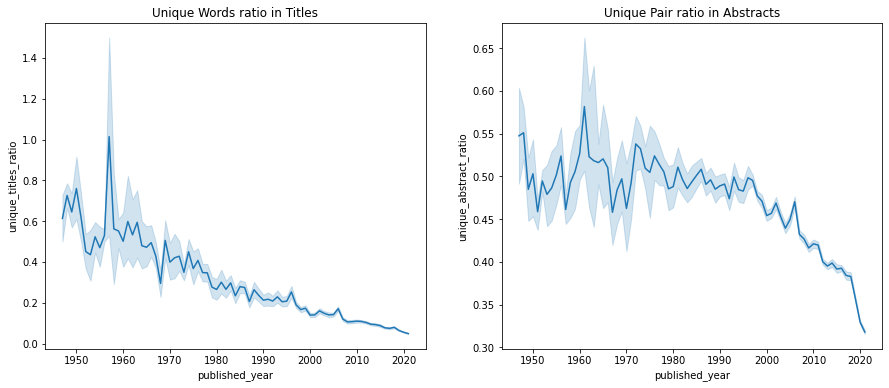

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.set_title("Unique Words ratio in Titles")
sns.lineplot(x= works["published_year"], y=works["unique_titles_ratio"],ax=ax1)
ax2.set_title("Unique Pair ratio in Abstracts")
sns.lineplot(x= works["published_year"], y=works["unique_abstract_ratio"],ax=ax2)

If we plot the values of our target value we see that we have a distribution problem. Most of our data is about close to 0 cdindex values.

So other data is not well represented.

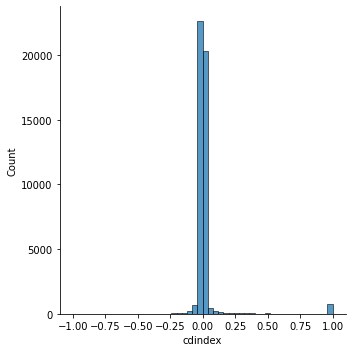

In [29]:
sns.displot(works["cdindex"], bins=50)

Normally we would like to implement an oversampling or undersampling technique to avoid this problem. After implementing SMOTE on binned target values there was no improvement to our models so we decided not to continue with it.

Although we have kept this part commented out.

In [30]:
# # divide cdindex into 8 groups
# works["binned_cdindex"] = pd.cut(works["cdindex"],8, labels=False)

# # keep the desired columns
# df = works.loc[:,"published_year":"binned_cdindex"].dropna()

# # take the values
# index = df.pop("binned_cdindex").values # we keep the binned cd index as target value
# features = df.values
# features_cols = df.columns

# # split train and test set
# X_train, X_test, y_train, y_test = train_test_split(features, index, test_size=0.75, 
#                                                     stratify=index, random_state=42)

# from imblearn.over_sampling import SMOTE

# # perform SMOTE to produce evenly distributed target values
# sm = SMOTE(k_neighbors=4,random_state=42)
# X_res, y_res = sm.fit_resample(X_train, y_train)

# # Now we throw away the binned cdindex and keep as target the new cdindex values SMOTE produced
# y_train = X_res[:,1]
# X_train = np.hstack((X_res[:,0:1],X_res[:,2:]))
# y_test = X_test[:,1]
# X_test = np.hstack((X_test[:,0:1],X_test[:,2:]))

# index = df.pop("cdindex").values
# features_cols = df.columns

---

After extracting as much data as we could from the dataset we have, we will start building a some regressors to se how good they can handle your data to provide predictions.

In [31]:
# DataFrame with the features values that we will use
df = works.loc[:,"published_year":"unique_abstract_ratio"].dropna()

# get the values 
index = df.pop("cdindex").values
features = df.values
features_cols = df.columns

We split our final dataset into training and testing datasets

In [32]:
X_train, X_test, y_train, y_test = train_test_split(features, index, test_size=0.25,random_state=42)

First we will see what a simple DecisionTreeRegressor can do.

We will perform a Grid Search to find the best depth for our tree

In [33]:
parameters = [{'max_depth': list(range(1, 10))}]

cv = KFold(n_splits=5, shuffle=True, random_state=42)
clf = GridSearchCV(DecisionTreeRegressor(), parameters, cv=cv)

clf = clf.fit(X_test, y_test)

print(clf.best_estimator_)
print(clf.best_params_)

DecisionTreeRegressor(max_depth=3)
{'max_depth': 3}


To evaluate our model's predicting ability we monitor the negative mean absolute error score.

In [34]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = -cross_val_score(clf.best_estimator_, X_train, y_train, cv=cv,scoring='neg_mean_absolute_error')
mean_score = np.mean(scores)
print(scores, mean_score, sem(scores))

clf.best_estimator_.fit(X_train, y_train)
pred = clf.best_estimator_.predict(X_test)
print(mean_absolute_error(y_test,pred))



[0.03668113 0.03694819 0.03487869 0.03249863 0.03464104] 0.035129533301371606 0.0008043056245430722
0.03615050281668712


We see that the mean score of the cross validation on the train dataset is 0.035. 

Testing on the test dataset we observe that the score is 0.036, very close to the train score.

This means that our predictions are off for about 0.036.

We can visualize the tree that was constructed to have a better understanding of it.

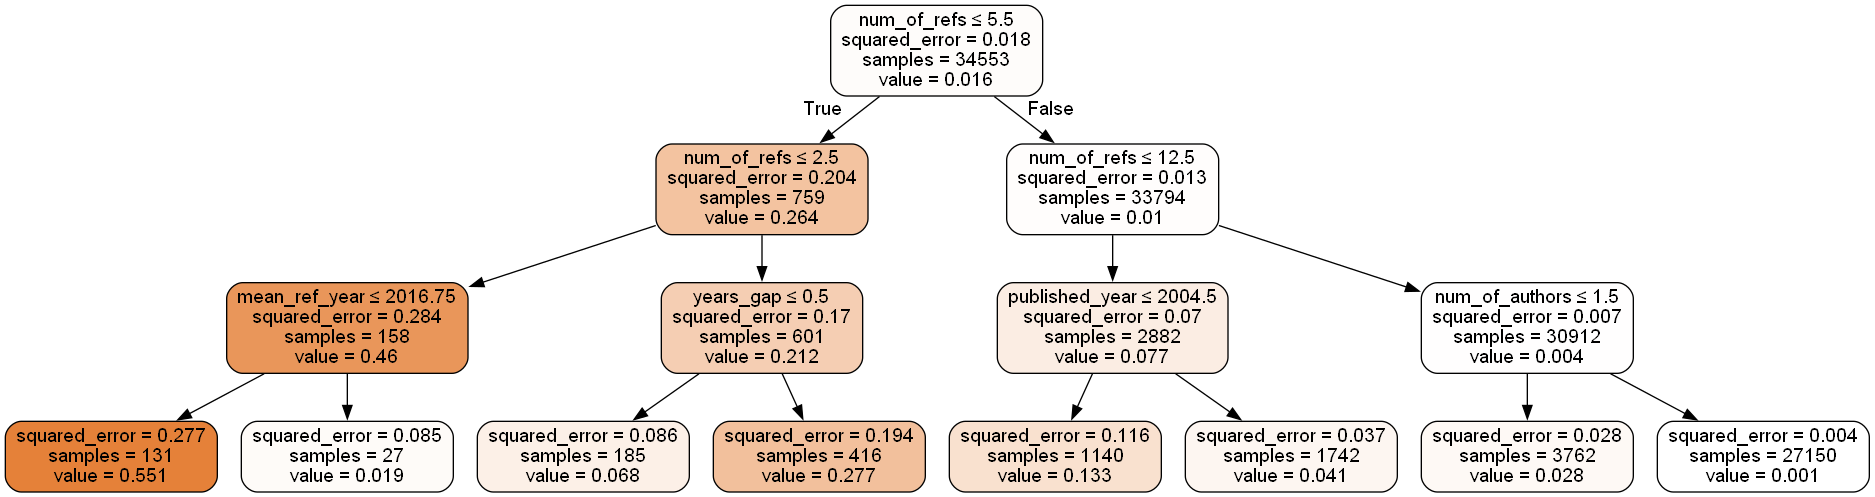

In [35]:
dot_data = StringIO()  
tree.export_graphviz(clf.best_estimator_, out_file=dot_data,  
                     feature_names=features_cols,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())  

Then we are going to try a XGBoost and a LightGBM Regressor

In [36]:
xgb_reg = xgb.XGBRegressor(n_estimators=50, random_state= 42)

scores = -cross_val_score(xgb_reg, X_train, y_train, scoring="neg_mean_absolute_error", cv=5)

xgb_reg.fit(X_train, y_train)
preds = xgb_reg.predict(X_test)

print(f"Cross Validation scores : {scores}")
print(f"Mean Cross Validation score : {np.mean(scores)}")
print(f"Mean Absolute Error on test data : {mean_absolute_error(y_test, preds)}")

Cross Validation scores : [0.03902198 0.03338319 0.03617188 0.03786261 0.03627227]
Mean Cross Validation score : 0.03654238389649204
Mean Absolute Error on test data : 0.036559478579089644


In [37]:
lgb_reg = lgb.LGBMRegressor(n_estimators=50, random_state= 42)

scores = -cross_val_score(lgb_reg, X_train, y_train, scoring="neg_mean_absolute_error", cv=5)

lgb_reg.fit(X_train, y_train, feature_name=list(features_cols))
preds = lgb_reg.predict(X_test)

print(f"Cross Validation scores : {scores}")
print(f"Mean Cross Validation score : {np.mean(scores)}")
print(f"Mean Absolute Error on test data : {mean_absolute_error(y_test, preds)}")

Cross Validation scores : [0.0361156  0.03022393 0.0325911  0.03484272 0.03364799]
Mean Cross Validation score : 0.03348426854264362
Mean Absolute Error on test data : 0.03468668592366335


Even though these Regressors are considered way better than the simple Decision Tree, the limitations of the dataset and the lack of good features to describe the target value, we see no significant improvement.

For better understanding we can also plot the importance of every feature in the two regressors.

Text(0.5, 1.0, 'Feature importance on LightGBMRegressor')

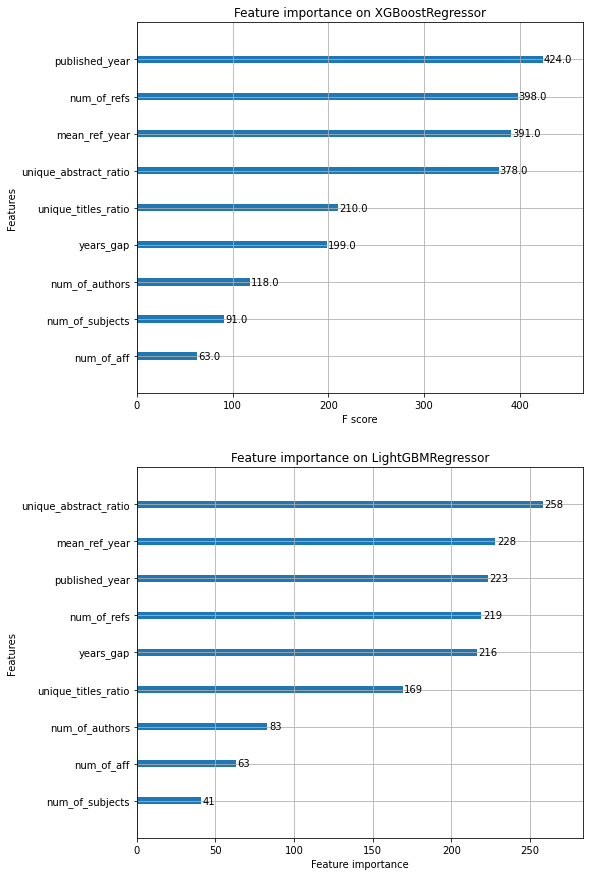

In [38]:
fig ,(ax1,ax2) = plt.subplots(2, 1,figsize=(8, 15))

xgb_reg.get_booster().feature_names = list(features_cols)
xgb.plot_importance(xgb_reg, ax = ax1)
ax1.set_title("Feature importance on XGBoostRegressor")

lgb.plot_importance(lgb_reg, figsize=(8, 6),ax=ax2)
ax2.set_title("Feature importance on LightGBMRegressor")

Lastly we are going to make two Ensemble models, a Voting Regressor and a Stacking Regressor.

For both ensembles we will use XGBoost and LightGBM estimators.

Voting Regressor:

In [39]:
xgb_reg = xgb.XGBRegressor(n_estimators=50)
lgb_reg = lgb.LGBMRegressor(n_estimators=50)
vreg = VotingRegressor(estimators=[('xgb', xgb_reg), 
                                   ('lgb', lgb_reg)],
                       n_jobs=-1)
                     
scores = -cross_val_score(vreg,  X_train, y_train,
                         cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

vreg.fit(X_train, y_train)
pred = vreg.predict(X_test)  

print(f"Cross Validation scores : {scores}")
print(f"Mean Cross Validation score : {np.mean(scores)}")
print(f"Mean Absolute Error on test data : {mean_absolute_error(y_test, pred)}")

Cross Validation scores : [0.03684892 0.0312033  0.03373942 0.03573711 0.03435641]
Mean Cross Validation score : 0.03437703009407109
Mean Absolute Error on test data : 0.03503429844620456


Stacking Regressor:

In [40]:
xgb_reg = xgb.XGBRegressor(n_estimators=50)
lgb_reg = lgb.LGBMRegressor(n_estimators=50)

estimators = [('xgb', xgb_reg), ('lgb', lgb_reg)]
final_estimator = LinearRegression()

sreg = StackingRegressor(estimators=estimators, final_estimator=final_estimator, n_jobs=-1)

scores = -cross_val_score(sreg, X_train, y_train,
                         cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

sreg.fit(X_train, y_train)
pred = sreg.predict(X_test)


print(f"Cross Validation scores : {scores}")
print(f"Mean Cross Validation score : {np.mean(scores)}")
print(f"Mean Absolute Error on test data : {mean_absolute_error(y_test, pred)}")

Cross Validation scores : [0.03598363 0.03015841 0.03249374 0.0346639  0.03351732]
Mean Cross Validation score : 0.03336339939708642
Mean Absolute Error on test data : 0.03438083543182294


We achieved some minor improvements with the ensemble models but overall the limitations of the dataset does not let us improve to the desired level.

---

Now let's explore the use of a Neural Network

We have the splitted dataset from the previous models.

This time we are going to perform a normalization to our data, as there is large variation among the feature columns.

In [41]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

We proceed to create the model.

We'll put the model creation code in a function.

In [42]:
def build_compile_model():
    model = keras.Sequential([
        normalizer,
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    
    return model

For our model we conclude that it will contain a Normalizer, two hidden layers consisted by 64 and 32 neutrons accordingly, and a final layer of one neuron that will produce the final prediction.

We define the loss function as the mean absolute error. This also helps us to make comparison with the decision trees results. 

Our optimizer will be the Adam optimizer.

In [43]:
model = build_compile_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,772
Trainable params: 2,753
Non-trainable params: 19
_________________________________________________________________


We set the initial number of epochs to 100 but we also define an Early Stopping condition that monitors the validation score and stops the epochs when no improvement is made in 10 consecutive ones.

We also define a bigger batch_size than the default as the dataset is very uneven and we want bigger samples to avoid misrepresentation.

In [44]:
num_epochs = 100

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    X_train, 
    y_train,
    epochs=num_epochs,
    batch_size=100,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop])

Epoch 1/100
277/277 [==============================] - 1s 2ms/step - loss: 0.0512 - val_loss: 0.0382
Epoch 2/100
277/277 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0344
Epoch 3/100
277/277 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0323
Epoch 4/100
277/277 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0313
Epoch 5/100
277/277 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0311
Epoch 6/100
277/277 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0305
Epoch 7/100
277/277 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0309
Epoch 8/100
277/277 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0305
Epoch 9/100
277/277 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0306
Epoch 10/100
277/277 [==============================] - 0s 2ms/step - loss: 0.0290 - val_lo

277/277 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0282
Epoch 82/100
277/277 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0282


Now we evaluate our model with the test data.

We see no deviation from the train data so there isn't any obvious overfitting

In [45]:
model.evaluate(X_test, y_test, verbose=0)

0.028923334553837776

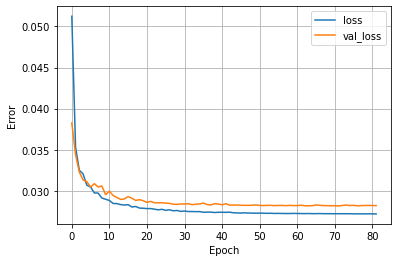

In [46]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    
plot_loss(history)